<a href="https://colab.research.google.com/github/chiragpipalia/ml_basics/blob/master/Fraud_Detection_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Also cover comparing models based on p-value/ hypothesis testing/ confidence interval

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
ls 'drive/My Drive/Colab Notebooks'

'ChatBot_Movie_Data (1).ipynb'     creditcard.csv
 ChatBot_Movie_Data.ipynb          Fraud_Detection_Baseline_Model.ipynb
'Copy of chatbot_tutorial.ipynb'   Untitled0.ipynb
 cornell_movie-dialogs_corpus/     Untitled1.ipynb


In [10]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [12]:
c = Counter(df.Class)
for k, v in c.items():
    print(f'Class {k}: Number of samples {v}; {round(v * 100 /len(df), 4)}% of total.')

Class 0: Number of samples 284315; 99.8273% of total.
Class 1: Number of samples 492; 0.1727% of total.


Highly imbalanced dataset. <br>
Only 492 samples for fraud transaction.

Lets check distributions of features. <br>
All the features except time and transaction amount are PCA tansformed

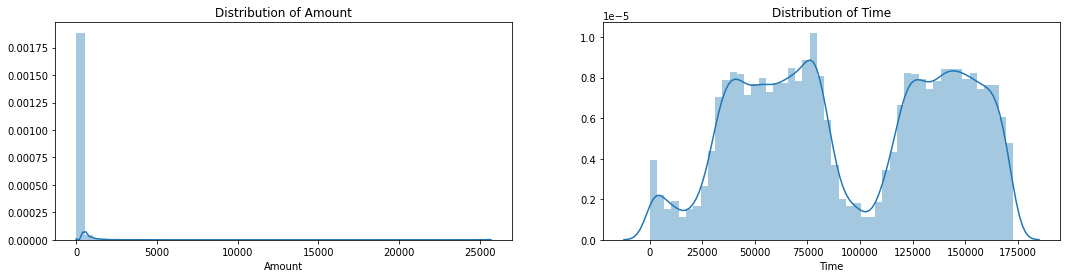

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))

sns.distplot(df.Amount, ax = ax[0])
ax[0].set_title('Distribution of Amount')

sns.distplot(df.Time, ax = ax[1])
ax[1].set_title('Distribution of Time')

plt.show()

Curious to check average amount of fraud and time

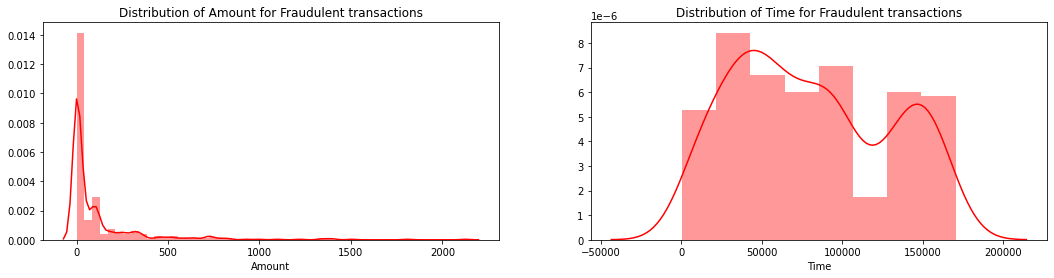

In [14]:
df_fraud = df.loc[df.Class == 1][['Time', 'Amount']]

fig, ax = plt.subplots(1, 2, figsize = (18, 4))

sns.distplot(df_fraud.Amount, ax = ax[0], color = 'red')
ax[0].set_title('Distribution of Amount for Fraudulent transactions')

sns.distplot(df_fraud.Time, ax = ax[1], color = 'red')
ax[1].set_title('Distribution of Time for Fraudulent transactions')

plt.show()

Not much difference in distribution for Class; surprisingly fraud amounts are not big

In [15]:
df_fraud.describe()

,Time,Amount
count,492.000000,492.000000
mean,80746.806911,122.211321
std,47835.365138,256.683288
min,406.000000,0.000000
25%,41241.500000,1.000000
50%,75568.500000,9.250000
75%,128483.000000,105.890000
max,170348.000000,2125.870000


In [16]:
scaler = RobustScaler()
df['ScaledAmt'] = scaler.fit_transform(df.Amount.to_numpy().reshape(-1, 1))
df['ScaledTime'] = scaler.fit_transform(df.Time.to_numpy().reshape(-1, 1))

df.drop(columns = ['Amount', 'Time'], inplace = True)

In [17]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,ScaledAmt,ScaledTime
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


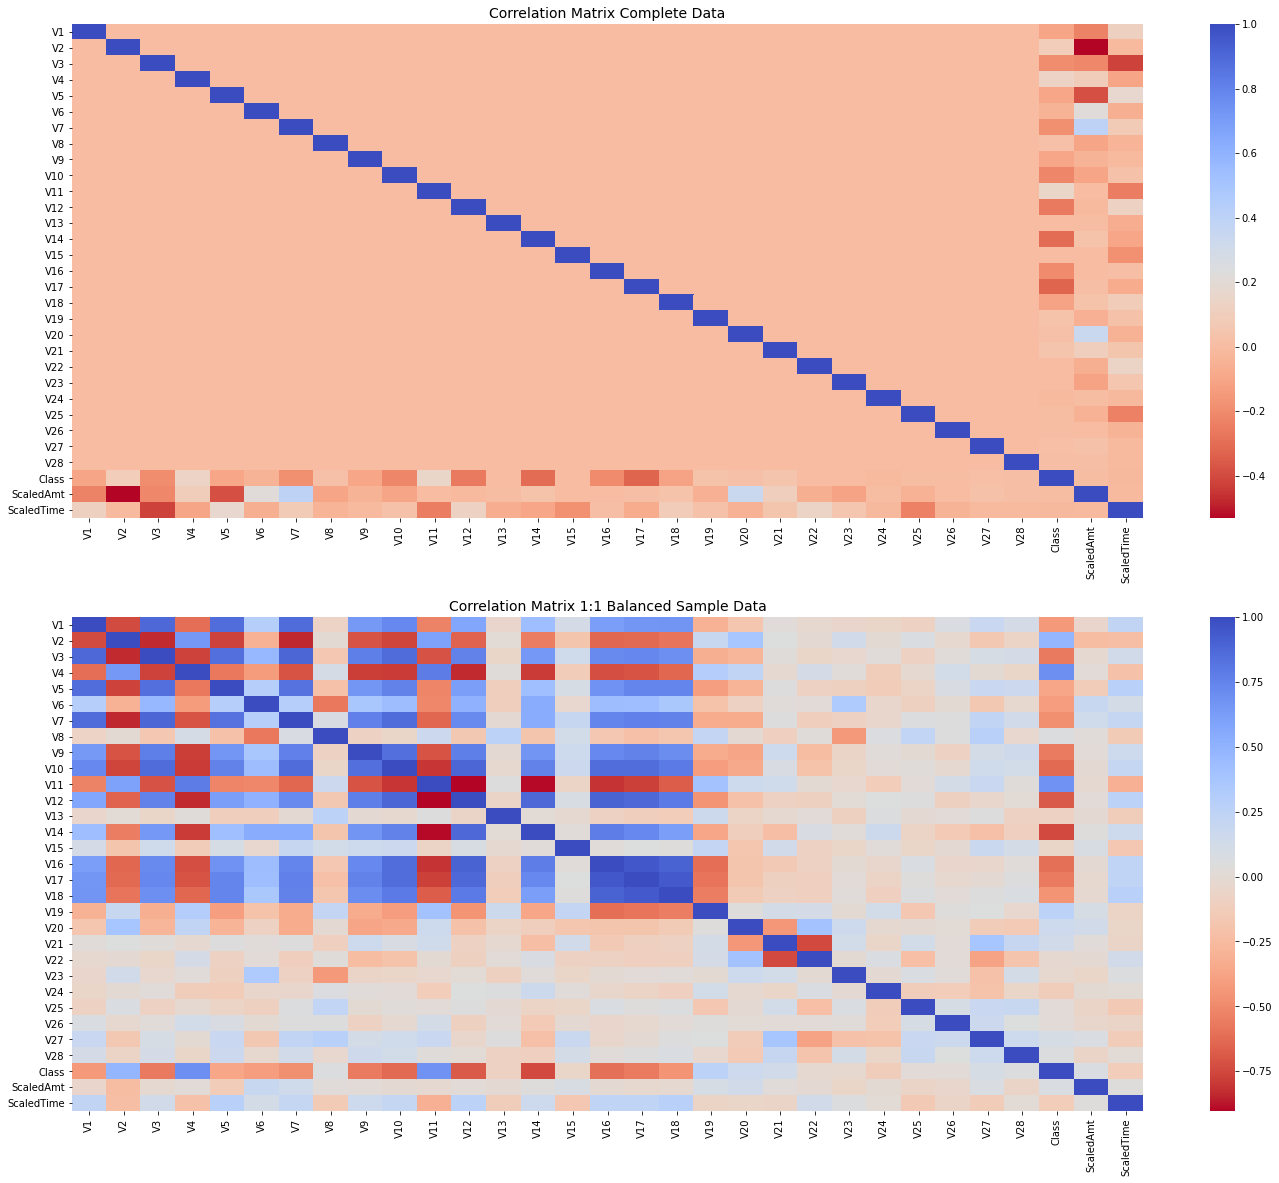

In [18]:
corr_df = df.corr()
df_fraud = df.loc[df.Class == 1]
sample_df = pd.concat([df.sample(n=len(df_fraud), random_state = 424).loc[df.Class == 0], df_fraud])

# Make sure we use the subsample in our correlation
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

sns.heatmap(corr_df, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Correlation Matrix Complete Data", fontsize=14)

sample_df_corr = sample_df.corr()
sns.heatmap(sample_df_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Correlation Matrix 1:1 Balanced Sample Data', fontsize=14)
plt.show()

## Cross validation methods

1. Keep original ratio 
2. Undersampling
3. Oversampling
4. Class weights

Benchmark with startified CV keeping the original ratio

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.metrics import *

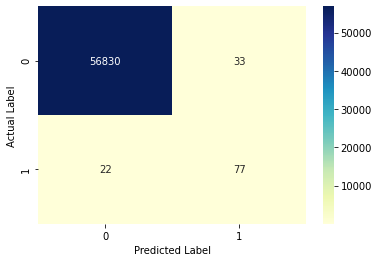

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.70      0.78      0.74        99

    accuracy                           1.00     56962
   macro avg       0.85      0.89      0.87     56962
weighted avg       1.00      1.00      1.00     56962

---------------------------------------------------------------------------
---------------------------------------------------------------------------


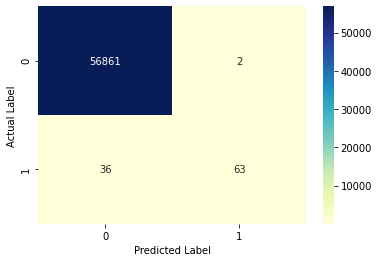

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.64      0.77        99

    accuracy                           1.00     56962
   macro avg       0.98      0.82      0.88     56962
weighted avg       1.00      1.00      1.00     56962

---------------------------------------------------------------------------
---------------------------------------------------------------------------


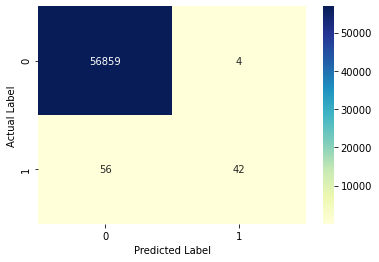

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.43      0.58        98

    accuracy                           1.00     56961
   macro avg       0.96      0.71      0.79     56961
weighted avg       1.00      1.00      1.00     56961

---------------------------------------------------------------------------
---------------------------------------------------------------------------


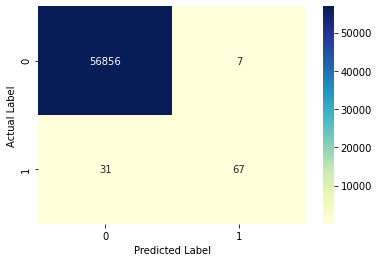

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.68      0.78        98

    accuracy                           1.00     56961
   macro avg       0.95      0.84      0.89     56961
weighted avg       1.00      1.00      1.00     56961

---------------------------------------------------------------------------
---------------------------------------------------------------------------


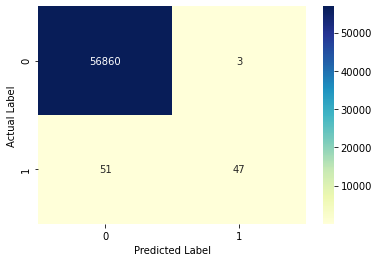

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.48      0.64        98

    accuracy                           1.00     56961
   macro avg       0.97      0.74      0.82     56961
weighted avg       1.00      1.00      1.00     56961

---------------------------------------------------------------------------
---------------------------------------------------------------------------
Mean precision: 0.8855359305794088
Mean recall score: 0.6011956297670583
Mean f1 score: 0.7005346048200632
Mean AUC: 0.8005116428560244


In [20]:
X = df.drop(columns = 'Class').values
y = df.Class.values

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

skf = StratifiedKFold(n_splits=5)
precision_lst, recall_lst, f1_lst, auc_lst = [], [], [], []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)
    precision_lst.append(precision_score(y_test, y_pred))
    recall_lst.append(recall_score(y_test, y_pred))
    f1_lst.append(f1_score(y_test, y_pred))
    auc_lst.append(roc_auc_score(y_test, y_pred))
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(classification_report(y_test, y_pred)) 
    print('---'*25)
    print('---'*25)
    
print(f'Mean precision: {np.mean(precision_lst)}')
print(f'Mean recall score: {np.mean(recall_lst)}')
print(f'Mean f1 score: {np.mean(f1_lst)}')
print(f'Mean AUC: {np.mean(auc_lst)}')

    

In [21]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

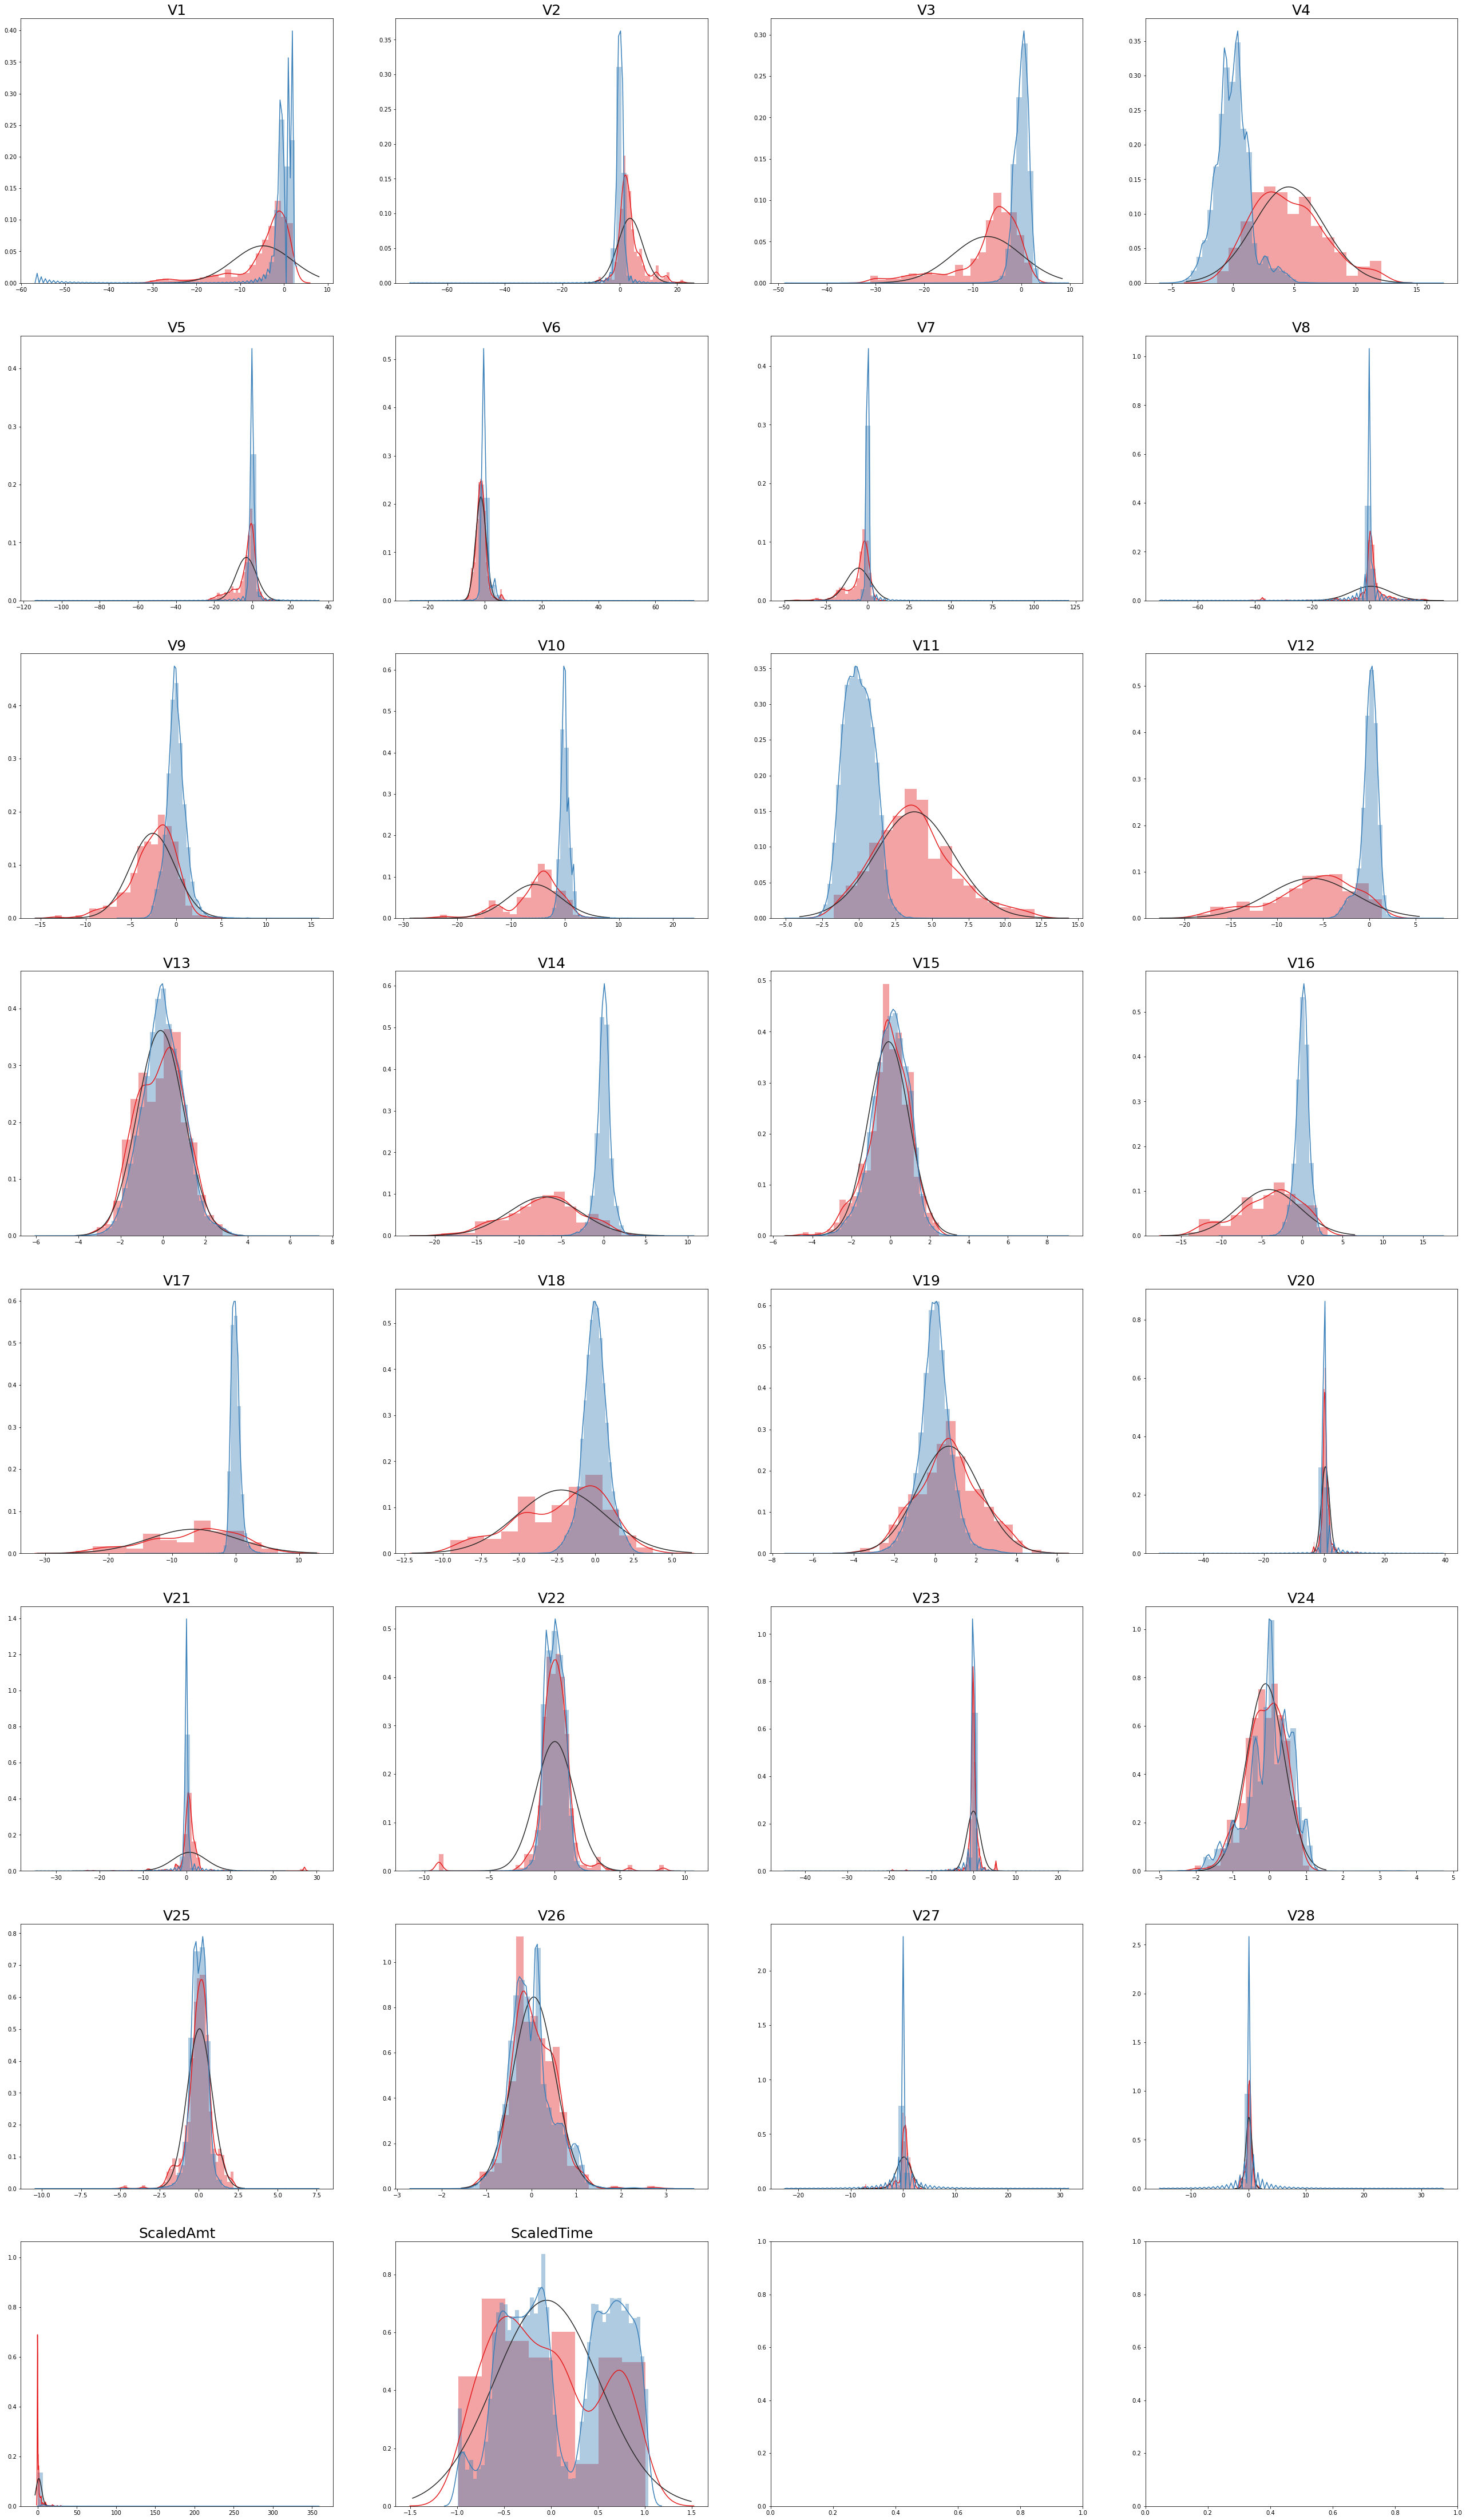

In [22]:
from scipy.stats import norm

features = df.columns.tolist()
features.remove('Class')

nrows, ncols = 8, 4
f, ax = plt.subplots(nrows = 8,  ncols= 4 , figsize=(45, 80))

cmap = sns.color_palette("Set2", 30)
cmap1 = sns.color_palette("Set1", 2)
#sns.husl_palette(10, h=.5)
i = 0
for row in range(nrows):
    for col in range(ncols):
        data = df[features[i]].loc[df['Class'] == 1].values
        sns.distplot(data, ax=ax[row, col], fit=norm, color = cmap1[0])
        
        data = df[features[i]].loc[df['Class'] == 0].values
        sns.distplot(data, ax=ax[row, col], color = cmap1[1])
        
        ax[row, col].set_title(f'{features[i]}',  fontsize=25)
        i+=1
        if i == 30:
            break


Features v4, v10, v11, v12, v14, v16 look well seperated for class 0 and class 1

In [23]:
import warnings
warnings.filterwarnings("ignore")

## Hyper parameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


skf = StratifiedKFold(n_splits=10)
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params)

precision_lst, recall_lst, f1_lst, auc_lst, model_params_lst = [], [], [], [], []

for train, test in skf.split(X, y):
    model = rand_log_reg.fit(X[train], y[train])
    best_est = rand_log_reg.best_estimator_
    model_params_lst.append(model.best_params_)
    prediction = best_est.predict(X[test])
    
    precision_lst.append(precision_score(y[test], prediction))
    recall_lst.append(recall_score(y[test], prediction))
    f1_lst.append(f1_score(y[test], prediction))
    auc_lst.append(roc_auc_score(y[test], prediction))
    
print('---' * 30)
print('')
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 30)


Checking parameters giving us best performance in each fold

In [ ]:
cv_list = list(zip(model_params_lst,precision_lst, recall_lst, f1_lst))
pd.DataFrame(cv_list, columns=['params', 'precision', 'recall', 'f1']).sort_values(by = 'f1', ascending = False)

,params,precision,recall,f1
2,"{'penalty': 'l2', 'C': 0.01}",0.976744,0.857143,0.913043
6,"{'penalty': 'l2', 'C': 0.1}",0.933333,0.840000,0.884211
8,"{'penalty': 'l2', 'C': 1000}",1.000000,0.551020,0.710526
0,"{'penalty': 'l2', 'C': 0.01}",0.573333,0.877551,0.693548
7,"{'penalty': 'l2', 'C': 0.1}",0.925926,0.510204,0.657895
5,"{'penalty': 'l2', 'C': 0.01}",1.000000,0.480000,0.648649
9,"{'penalty': 'l2', 'C': 0.1}",0.862069,0.510204,0.641026
4,"{'penalty': 'l2', 'C': 0.1}",0.869565,0.408163,0.555556
1,"{'penalty': 'l2', 'C': 10}",1.000000,0.346939,0.515152
3,"{'penalty': 'l2', 'C': 0.01}",1.000000,0.285714,0.444444


Different parameters seems to give best results (looking at f1 mostly), this is not concusively 

We could try some feature engineering.

* Select features seperable distribution for each class
* Selecting feature more correlated with target
* Detect and remove multicorrelated features

## Tree based model

### Baseline tree model

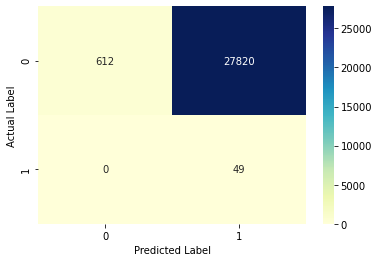

              precision    recall  f1-score   support

           0       1.00      0.02      0.04     28432
           1       0.00      1.00      0.00        49

    accuracy                           0.02     28481
   macro avg       0.50      0.51      0.02     28481
weighted avg       1.00      0.02      0.04     28481

Total time taken: 143.05578804016113
------------------------------------------------------------------------------------------


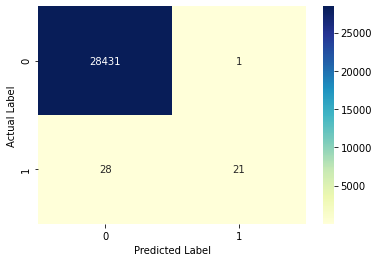

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.95      0.43      0.59        49

    accuracy                           1.00     28481
   macro avg       0.98      0.71      0.80     28481
weighted avg       1.00      1.00      1.00     28481

Total time taken: 141.55267882347107
------------------------------------------------------------------------------------------


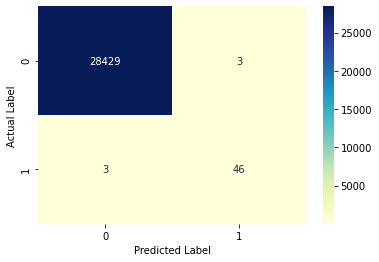

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.94      0.94      0.94        49

    accuracy                           1.00     28481
   macro avg       0.97      0.97      0.97     28481
weighted avg       1.00      1.00      1.00     28481

Total time taken: 131.82344889640808
------------------------------------------------------------------------------------------


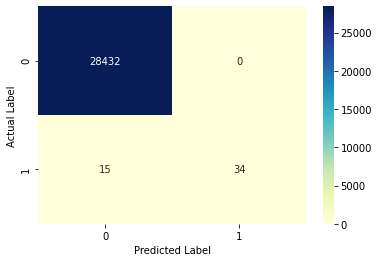

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       1.00      0.69      0.82        49

    accuracy                           1.00     28481
   macro avg       1.00      0.85      0.91     28481
weighted avg       1.00      1.00      1.00     28481

Total time taken: 125.26088809967041
------------------------------------------------------------------------------------------


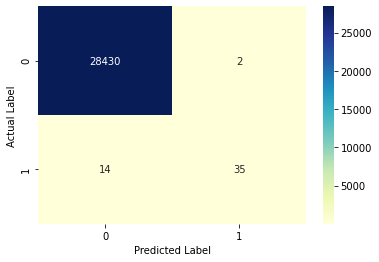

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.95      0.71      0.81        49

    accuracy                           1.00     28481
   macro avg       0.97      0.86      0.91     28481
weighted avg       1.00      1.00      1.00     28481

Total time taken: 131.21365404129028
------------------------------------------------------------------------------------------


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time


precision_lst, recall_lst, f1_lst, auc_lst, model_params_lst = [], [], [], [], []

for train_index, test_index in skf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestClassifier(n_jobs =-1)
    model.fit(X_train, y_train)
     
    y_pred = model.predict(X_test)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(classification_report(y_test, y_pred))
    print(f'Total time taken: {time.time() - start_time}')
    print('---'*30)
    
    precision_lst.append(precision_score(y_test, y_pred))
    recall_lst.append(recall_score(y_test, y_pred))
    f1_lst.append(f1_score(y_test, y_pred))
    auc_lst.append(roc_auc_score(y_test, y_pred))
    
print('---' * 30)
print('')
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 30)
    

### Try same model with undersample, oversample and class weights

## Lets Grid Search few algos and compare results

## Plot Precision Recall Curve as metric